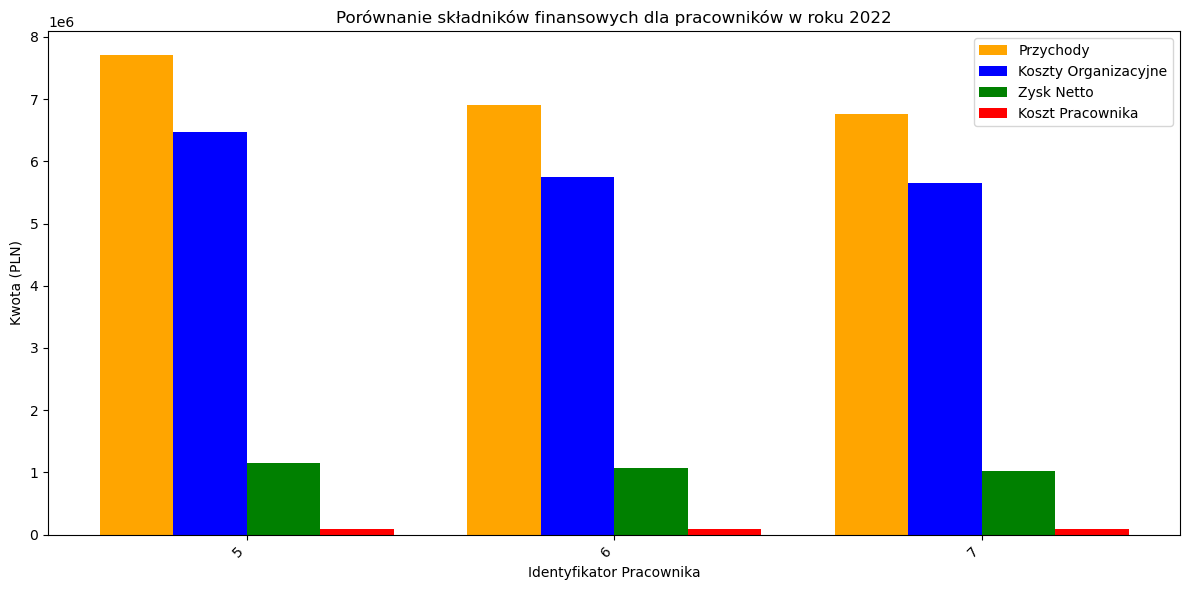

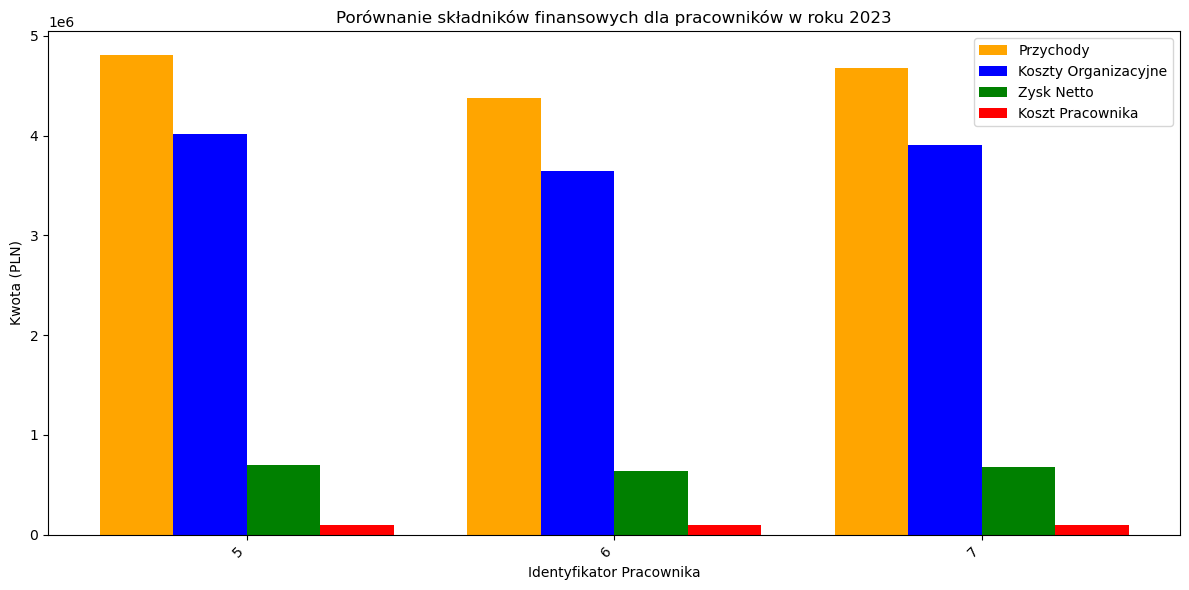

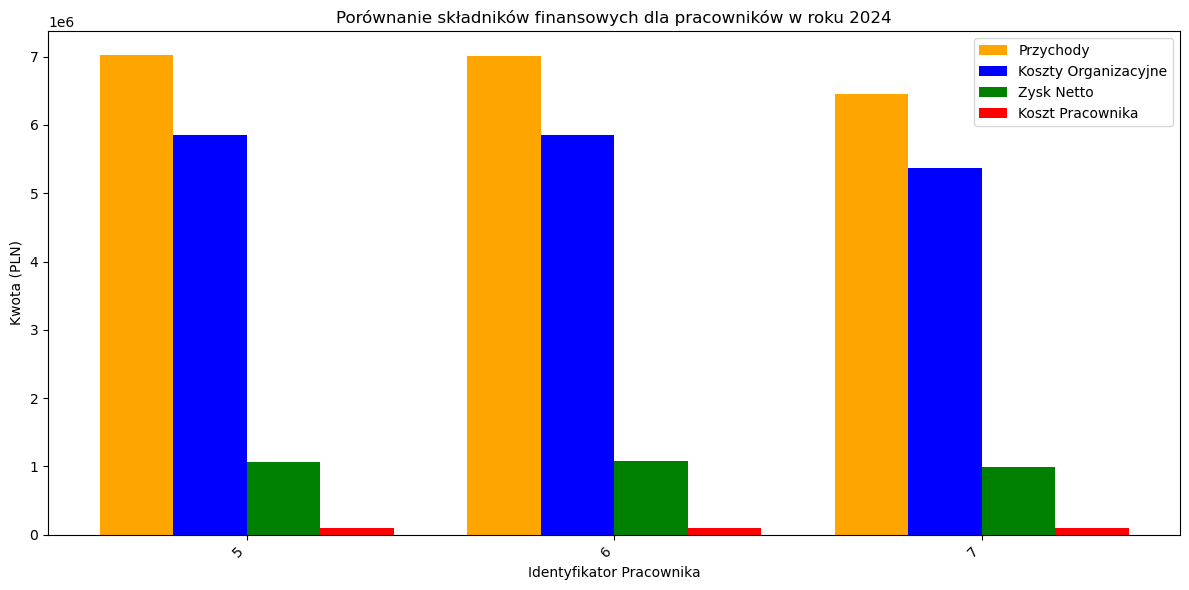

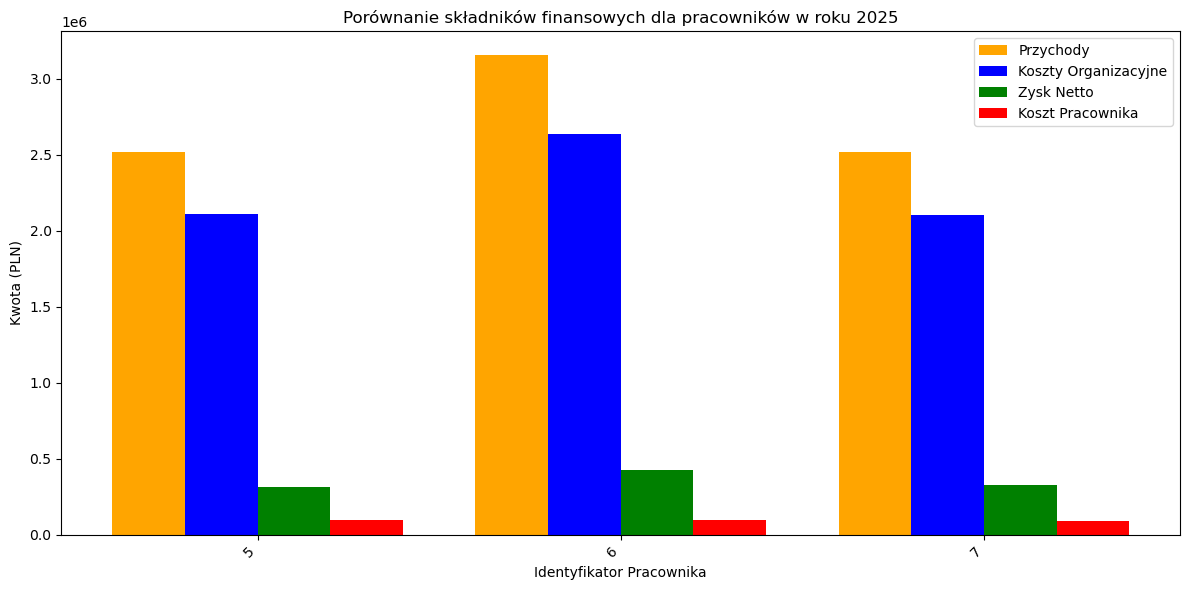

In [32]:
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np

# Połączenie z bazą danych
connection = mysql.connector.connect(
    host="giniewicz.it",
    user="team19",
    password="te@mzaiq",
    database="team19"
)

cursor = connection.cursor()

# Zapytanie SQL dla danych
query = """
SELECT 
    p.id_pracownicy AS IdPracownika,
    CONCAT(p.Imie, ' ', p.Nazwisko) AS Pracownik,
    YEAR(r.Data_rezerwacji) AS Rok,
    SUM(rw.Cena_za_osobe) AS Przychody,
    SUM(
        ko.Nocleg_za_noc * rw.Ilosc_nocy +
        ko.Przewodnik +
        ko.Loty +
        ko.Atrakcje +
        ko.Ubezpieczenie +
        ko.Transport
    ) AS KosztyOrganizacyjne,
    (
        p.Pensja * 12 + COALESCE(s.Koszt_stanowiska, 0) * 12
    ) AS KosztPracownika,
    SUM(rw.Cena_za_osobe) - 
    (
        p.Pensja * 12 + COALESCE(s.Koszt_stanowiska, 0) * 12
    ) -
    SUM(
        ko.Nocleg_za_noc * rw.Ilosc_nocy +
        ko.Przewodnik +
        ko.Loty +
        ko.Atrakcje +
        ko.Ubezpieczenie +
        ko.Transport
    ) AS ZyskNetto
FROM 
    Pracownicy p
JOIN 
    Rezerwacje r ON p.id_pracownicy = r.id_pracownicy
JOIN 
    Realizowane_wycieczki rw ON r.id_wycieczki = rw.id_wycieczki
JOIN 
    Koszty_organizacji ko ON rw.id_koszty = ko.id_koszty
LEFT JOIN 
    Stanowisko s ON p.id_stanowisko = s.id_stanowisko
WHERE 
    p.id_pracownicy IN (5, 6, 7)
GROUP BY 
    p.id_pracownicy, Pracownik, Rok
ORDER BY 
    Rok, IdPracownika;
"""

# Wykonanie zapytania SQL
cursor.execute(query)
results = cursor.fetchall()

# Zamknięcie połączenia z bazą danych
cursor.close()
connection.close()

# Przetwarzanie wyników
data_by_year = {}
for row in results:
    id_pracownicy = row[0]  # Używamy id_pracownicy
    rok = row[2]
    przychody = row[3]
    koszty_organizacyjne = row[4]
    zysk_netto = row[6]
    koszt_pracownika = row[5]

    if rok not in data_by_year:
        data_by_year[rok] = []
    data_by_year[rok].append({
        'id_pracownicy': id_pracownicy,  # Używamy id_pracownicy
        'przychody': przychody,
        'koszty_organizacyjne': koszty_organizacyjne,
        'zysk_netto': zysk_netto,
        'koszt_pracownika': koszt_pracownika
    })

# Generowanie wykresów dla każdego roku
for rok, dane in data_by_year.items():
    pracownicy = [entry['id_pracownicy'] for entry in dane]  # Używamy id_pracownicy
    przychody = [entry['przychody'] for entry in dane]
    koszty_organizacyjne = [entry['koszty_organizacyjne'] for entry in dane]
    zyski_netto = [entry['zysk_netto'] for entry in dane]
    koszty_pracownika = [entry['koszt_pracownika'] for entry in dane]

    x = np.arange(len(pracownicy))  # Oś X
    width = 0.2  # Szerokość słupków

    plt.figure(figsize=(12, 6))

    # Dodanie słupków w odpowiedniej kolejności
    plt.bar(x - 1.5 * width, przychody, width, label='Przychody', color='orange')
    plt.bar(x - 0.5 * width, koszty_organizacyjne, width, label='Koszty Organizacyjne', color='blue')
    plt.bar(x + 0.5 * width, zyski_netto, width, label='Zysk Netto', color='green')
    plt.bar(x + 1.5 * width, koszty_pracownika, width, label='Koszt Pracownika', color='red')

    # Dodanie etykiet i tytułów
    plt.title(f'Porównanie składników finansowych dla pracowników w roku {rok}')
    plt.xlabel('Identyfikator Pracownika')  # Używamy id_pracownicy
    plt.ylabel('Kwota (PLN)')
    plt.xticks(x, pracownicy, rotation=45, ha='right')  # Ustawienie id_pracownicy na osi X
    plt.legend()

    # Wyświetlenie wykresu
    plt.tight_layout()
    plt.show()
